## Explainable AI in Lending Workshop

1. Building a simple credit risk model using machine learning
2. Explaining the model using model coefficients
3. Using Shapley values to explain predictions
4. Counterfactual explainability
5. Using LLMs to explain decisions

In [2]:
# imports

import pandas as pd

### 1. Building a simple credit risk model using machine learning

The following features have been taken from [Kaggle - GiveMeSomeCredit](https://www.kaggle.com/c/GiveMeSomeCredit/data).

Number | Variable Name | Description | Type
--- | --- | --- | ---
1 | **SeriousDlqin2yrs** | Person experienced 90 days past due delinquency or worse | *categorical (y (1)/ n (0))*
2 | **RevolvingUtilizationOfUnsecuredLines** | Total balance on credit cards and personal lines of credit except real estate and no installment debt | *real (percentage)*
3 | **age** | Age of borrower in years | *int*
4 | **NumberOfTime30-59DaysPastDueNotWorse** | Number of times borrower has been 30-59 days past due but no worse in the last 2 years | *int*
5 | **DebtRatio** | Monthly debt payments, alimony,living costs divided by monthy gross income | *real (percentage)*
6 | **MonthlyIncome** | Monthly income | *real*
7 | **NumberOfOpenCreditLinesAndLoans** | Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards) | *int*
8 | **NumberOfTimes90DaysLate** | Number of times borrower has been 90 days or more past due | *int*
9 | **NumberRealEstateLoansOrLines** | Number of mortgage and real estate loans including home equity lines of credit | *int*
10 | **NumberOfTime60-89DaysPastDueNotWorse** | Number of times borrower has been 60-89 days past due but no worse in the last 2 years | *int*
11 | **NumberOfDependents** | Number of dependents in family excluding themselves (spouse, children etc.) | *int*

I have added the following features:

Number | Variable Name | Description | Type
--- | --- | --- | ---
12 | **Avg30DayGamblingSpend** | Average monthly spend on gambling activities | *real*
13 | **Avg30DayCashWithdrawals** | Average monthly cash withdrawals | *real*
14 | **NumberOfDirectDebitsFailingLast30Days** | Number of Direct Debits failed in the last 30 days | *int*
15 | **CreditCardUsedForUtilities** | Whether a credit card was used for utilities payments | *bool*
16 | **OnBenefits** | Whether or not the applicant is on benefits | *bool*

In [22]:
df = pd.read_csv('../data/cs-training.csv', index_col=[0])



In [23]:
df['SeriousDlqin2yrs'].value_counts()

0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64

In [24]:
df = df.sample(1000, weights='NumberOfTime60-89DaysPastDueNotWorse')

In [97]:
import numpy as np
from scipy.stats import beta

df['Avg30DayGamblingSpend'] = np.nan
df.loc[df['SeriousDlqin2yrs'] == 0, 'Avg30DayGamblingSpend'] = beta.rvs(2, 3, loc=30, scale=100, size=df[df['SeriousDlqin2yrs'] == 0].shape[0])
df.loc[df['SeriousDlqin2yrs'] == 1, 'Avg30DayGamblingSpend'] = beta.rvs(2, 20, loc=125, scale=200, size=df[df['SeriousDlqin2yrs'] == 1].shape[0])
df['Avg30DayGamblingSpend'] = df['Avg30DayGamblingSpend'].clip(0, 0.9*df['MonthlyIncome'])

df['Avg30DayCashWithdrawals'] = np.nan
df.loc[df['SeriousDlqin2yrs'] == 0, 'Avg30DayCashWithdrawals'] = beta.rvs(2, 3, loc=30, scale=100, size=df[df['SeriousDlqin2yrs'] == 0].shape[0])
df.loc[df['SeriousDlqin2yrs'] == 1, 'Avg30DayCashWithdrawals'] = beta.rvs(2, 20, loc=50, scale=200, size=df[df['SeriousDlqin2yrs'] == 1].shape[0])
df['Avg30DayCashWithdrawals'] = df['Avg30DayCashWithdrawals'].clip(0, 0.1*df['MonthlyIncome'])

In [98]:
df

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,Avg30DayGamblingSpend,Avg30DayCashWithdrawals
15677,0,1.268255,35,2,0.012240,37500.0,5,2,0,3,1.0,67.979232,69.185371
49327,1,1.000000,22,98,0.000000,0.0,0,98,0,98,0.0,0.000000,0.000000
109250,1,1.000000,55,98,0.008074,2600.0,0,98,0,98,0.0,146.483165,70.209151
11363,1,1.000000,27,98,0.000000,NaN,0,98,0,98,0.0,125.354775,83.019186
62669,0,1.000000,27,98,0.000000,2400.0,0,98,0,98,0.0,97.934807,109.686549
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63468,0,0.128027,56,0,2140.000000,NaN,14,0,1,1,NaN,76.892594,81.656077
61111,0,0.008590,51,0,2520.000000,NaN,9,0,1,1,NaN,76.226150,36.419360
86059,1,0.252696,36,1,0.431142,4000.0,11,0,0,2,3.0,144.784333,56.137600
6845,1,0.083832,31,1,0.056633,5208.0,5,0,0,1,0.0,134.420355,56.709360


<Axes: >

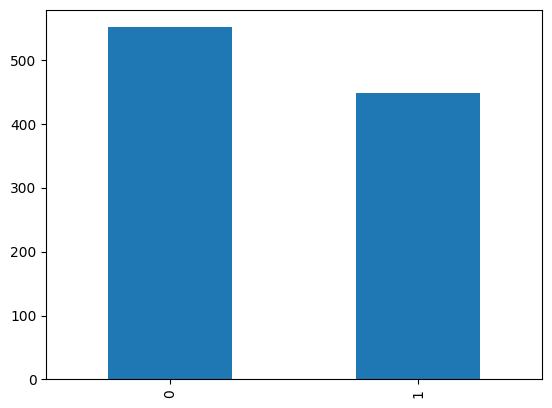

In [28]:
df['SeriousDlqin2yrs'].value_counts().plot.bar()

In [34]:
import seaborn as sns

df['RevolvingUtilizationOfUnsecuredLines'].describe()

count    1000.000000
mean        6.980269
std       195.720378
min         0.000000
25%         0.562622
50%         0.996539
75%         1.000000
max      6190.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64